In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import textstat
from scipy import sparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
print("Downloading NLTK Data, Please Wait...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# Loading Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
filepath = "blog-gender-dataset.xlsx"
df = pd.read_excel(filepath, header=None)

# Select first two columns
df = df.iloc[:, :2]

# Rename Columns
df.columns = ['blog_text', 'gender']

# Data Cleaning

In [ ]:
# Convert to correct datatype and remove surrounding whitespace
df['blog_text'] = df['blog_text'].astype(str).str.strip()
df['gender'] = df['gender'].astype(str).str.strip().str.upper()

# Remove rows that do not have valid data
df.dropna()
df = df[df['gender'].isin(("M", "F"))].copy()
df.head()

,blog_text,gender
0,Long time no see. Like always I was rewriting ...,M
1,Guest Demo: Eric Iverson’s Itty Bitty Search\n...,M
2,Who moved my Cheese??? The world has been de...,M
3,Yesterday I attended a biweekly meeting of an ...,M
4,Liam is nothing like Natalie. Natalie never we...,F


# Exploratory Data Analysis

In [ ]:
# Setting blog text type
df['blog_text'] = df['blog_text'].astype(str)

# Count of words in each blog text
df['word_count'] = df['blog_text'].apply(lambda x: len(x.split()))

# Count of sentenses in each blog text
df['sentence_count'] = df['blog_text'].apply(
    lambda x: len([s for s in x.split('.') if s.strip() != ""])
)

total_samples = len(df)
gender_distribution = df['gender'].value_counts()
avg_word_count = df['word_count'].mean()
avg_sentence_count = df['sentence_count'].mean()

print("Total samples:", total_samples)
print("Gender distribution:")
print(gender_distribution)
print("Average word count:", avg_word_count)
print("Average sentence count:", avg_sentence_count)

Total samples: 3227
Gender distribution:
gender
M    1679
F    1548
Name: count, dtype: int64
Average word count: 419.9079640533003
Average sentence count: 24.650449333746515


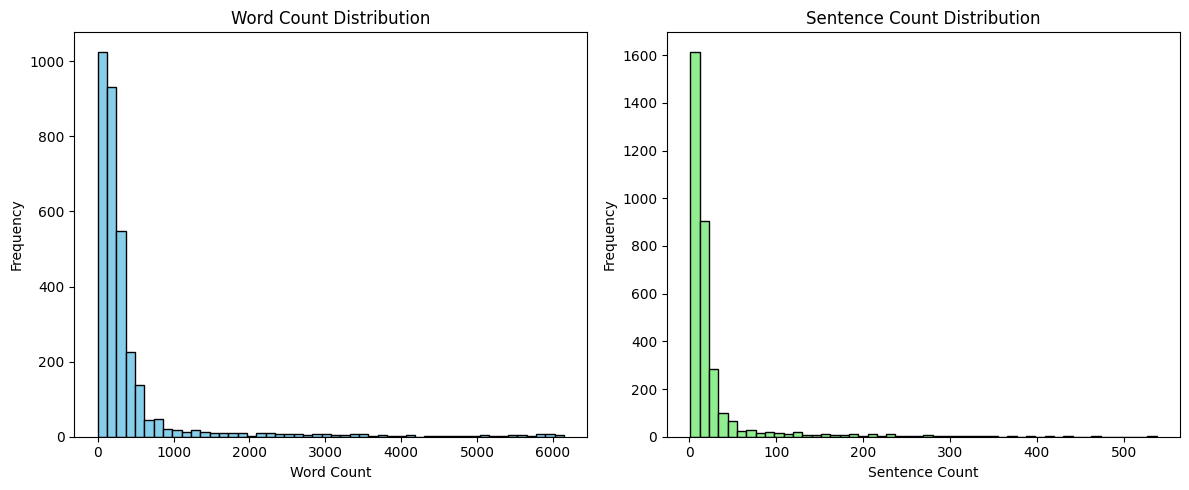

In [ ]:
plt.figure(figsize=(12, 5))

# Plot of word count distribution
plt.subplot(1, 2, 1)
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Plot of sentence count distribution
plt.subplot(1, 2, 2)
plt.hist(df['sentence_count'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Sentence Count Distribution")
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

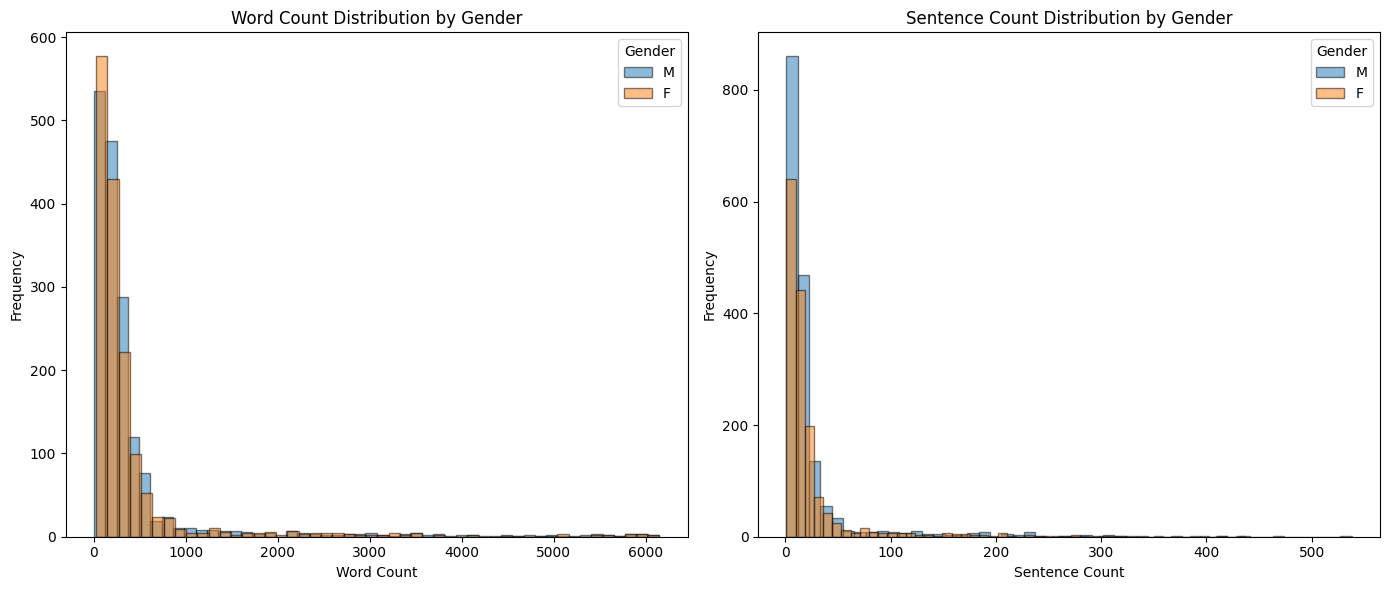

In [ ]:
plt.figure(figsize=(14, 6))

# Plot the word count distribution by gender
plt.subplot(1, 2, 1)
for gender in df['gender'].unique():
    subset = df[df['gender'] == gender]
    plt.hist(subset['word_count'], bins=50, alpha=0.5, label=gender, edgecolor='black')
plt.title("Word Count Distribution by Gender")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title="Gender")

# Plot the sentence count distribution by gender
plt.subplot(1, 2, 2)
for gender in df['gender'].unique():
    subset = df[df['gender'] == gender]
    plt.hist(subset['sentence_count'], bins=50, alpha=0.5, label=gender, edgecolor='black')
plt.title("Sentence Count Distribution by Gender")
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.legend(title="Gender")

plt.tight_layout()
plt.show()

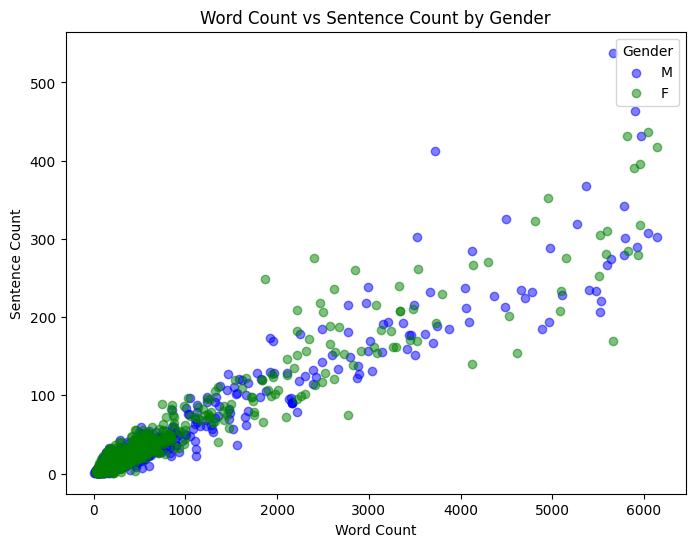

In [ ]:
plt.figure(figsize=(8, 6))

genders = df['gender'].unique()
colors = {'M': 'blue', 'F': 'green'}

# Scatter plot of Word Count vs Sentence Count
for gender in genders:
    subset = df[df['gender'] == gender]
    plt.scatter(subset['word_count'], subset['sentence_count'],
                alpha=0.5, label=gender, color=colors[gender])

plt.xlabel("Word Count")
plt.ylabel("Sentence Count")
plt.title("Word Count vs Sentence Count by Gender")
plt.legend(title="Gender")
plt.show()


# Baseline Implementation
## words, word classes, pos n-grams

In [ ]:
# Generate POS sequences for each blog post
class PosTagGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        pos_sequences = []
        for text in X:
            tokens = nltk.word_tokenize(text)
            # extract POS tags only
            tags = [tag for word, tag in nltk.pos_tag(tokens)]
            pos_sequences.append(" ".join(tags))
        return pos_sequences


# Generate the count of number of words of belonging to a class for each class in each blog post
class WordClassGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Word classes taken from Mukherjee and Liu 2010
        self.word_classes = {
            'conversation': ["know", "people", "think", "person", "tell", "feel", "friends",
                             "talk", "new", "talking", "mean", "ask", "understand", "feelings",
                             "care", "thinking", "friend", "relationship", "realize", "question",
                             "answer", "saying"],
            'home': ["woke", "home", "sleep", "today", "eat", "tired", "wake", "watch",
                     "watched", "dinner", "ate", "bed", "day", "house", "tv", "early",
                     "boring", "yesterday", "watching", "sit"],
            'family': ["years", "family", "mother", "children", "father", "kids", "parents",
                       "old", "year", "child", "son", "married", "sister", "dad", "brother",
                       "moved", "age", "young", "months", "three", "wife", "living", "college",
                       "four", "high", "five", "died", "six", "baby", "boy", "spend"],
            'love': ["forget", "forever", "remember", "gone", "true", "face", "spent",
                        "times", "love", "cry", "hurt", "wish", "loved"],
            'lifestyle': ["food", "eating", "weight", "lunch", "water", "hair", "life", "white",
                             "wearing", "color", "ice", "red", "fat", "body", "black", "clothes",
                             "hot", "drink", "wear", "blue", "minutes", "shirt", "green", "coffee",
                             "total", "store", "shopping"]
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for text in X:
            text_lower = text.lower()
            text_features = {}
            for cls, words in self.word_classes.items():
                count = 0
                for word in words:
                    # Matches individual words
                    count += len(re.findall(r'\b' + re.escape(word) + r'\b', text_lower))
                text_features[cls] = count
            features.append(text_features)
        return features


# Sparse to Dense conversion for Decision Tree and Random Forest as these require dense representation
class DenseGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if sparse.issparse(X):
            return X.toarray()
        return X


# F-measure Generator based on POS counts
class FMeasureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Define POS tag sets
        self.nouns   = {"NN", "NNS", "NNP", "NNPS"}
        self.adjs    = {"JJ", "JJR", "JJS"}
        self.preps   = {"IN"}
        self.arts    = {"DT"}
        self.prons   = {"PRP", "PRP$", "WP", "WP$"}
        self.verbs   = {"VB", "VBD", "VBG", "VBN", "VBP", "VBZ"}
        self.advs    = {"RB", "RBR", "RBS"}
        self.interjs = {"UH"}

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        f_measure_values = []
        for text in X:
            tokens = nltk.word_tokenize(text)
            pos_tags = nltk.pos_tag(tokens)
            counts = {
                'noun': sum(1 for word, tag in pos_tags if tag in self.nouns),
                'adj':  sum(1 for word, tag in pos_tags if tag in self.adjs),
                'prep': sum(1 for word, tag in pos_tags if tag in self.preps),
                'art':  sum(1 for word, tag in pos_tags if tag in self.arts),
                'pron': sum(1 for word, tag in pos_tags if tag in self.prons),
                'verb': sum(1 for word, tag in pos_tags if tag in self.verbs),
                'adv':  sum(1 for word, tag in pos_tags if tag in self.advs),
                'interj': sum(1 for word, tag in pos_tags if tag in self.interjs)
            }
            # F-measure = 0.5 × number of ((nouns + adjectives + prepositions + articles) −
            # (pronouns + verbs + adverbs + interjections) + 100)
            F = 0.5 * ((counts['noun'] + counts['adj'] + counts['prep'] + counts['art']) -
                       (counts['pron'] + counts['verb'] + counts['adv'] + counts['interj']) + 100)
            F = max(F, 0)  # Converting negative F-measures to 0
            f_measure_values.append({'F_measure': F})
        return f_measure_values

# Suffix Patterns based Generator as described in Mukherjee and Liu 2010
class SuffixPatternsGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Suffix patterns dict
        self.suffixes = {
            "end_with_able": "able",
            "end_with_al": "al",
            "end_with_ful": "ful",
            "end_with_ible": "ible",
            "end_with_ic": "ic",
            "end_with_ive": "ive",
            "end_with_less": "less",
            "end_with_ly": "ly",
            "end_with_ous": "ous"
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for text in X:
            text_lower = text.lower()
            text_features = {}
            for feature_name, suffix in self.suffixes.items():
                text_features[feature_name] = len(re.findall(r'\b\w+' + re.escape(suffix) + r'\b', text_lower))
            # Count "sorry" words
            text_features["sorry_words"] = len(re.findall(r'\bsorry\b', text_lower))
            features.append(text_features)
        return features

# Word-based feature
word_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english'))
])

# Word Class feature
word_class_pipeline = Pipeline([
    ('word_class', WordClassGenerator()),
    ('dict_vect', DictVectorizer(sparse=False))
])

# POS n-gram feature
pos_pipeline = Pipeline([
    ('pos_tags', PosTagGenerator()),
    ('vectorizer', CountVectorizer(ngram_range=(1, 2)))
])

# F-measure feature
f_measure_pipeline = Pipeline([
    ('f_measure', FMeasureGenerator()),
    ('dict_vect', DictVectorizer(sparse=False))
])

# Suffix patterns feature
suffix_pipeline = Pipeline([
    ('gender_pref', SuffixPatternsGenerator()),
    ('dict_vect', DictVectorizer(sparse=False))
])

# Combine all features using FeatureUnion.
combined_features = FeatureUnion([
    ('word_features', word_pipeline),
    ('word_class_features', word_class_pipeline),
    ('pos_ngram_features', pos_pipeline),
    ('f_measure_features', f_measure_pipeline),
    ('gender_pref_features', suffix_pipeline)
])

X = df['blog_text']
y = df['gender']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

classifiers = {
    "LinearSVC": LinearSVC(max_iter=10000),
    "NaiveBayes": MultinomialNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Training and Evaluation
for clf_name, clf in classifiers.items():
    print("\n" + "="*40)
    print(f"Classifier: {clf_name}")

    # For DecisionTree and RandomForest, convert sparse feature matrix to dense.
    if clf_name in ["DecisionTree", "RandomForest"]:
        pipeline = Pipeline([
            ('features', combined_features),
            ('to_dense', DenseGenerator()),
            ('clf', clf)
        ])
    else:
        pipeline = Pipeline([
            ('features', combined_features),
            ('clf', clf)
        ])

    pipeline.fit(X_train, y_train_enc)
    y_pred_enc = pipeline.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred_enc)
    print(f"Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))


Classifier: LinearSVC
Accuracy: 65.02%
Classification Report:
              precision    recall  f1-score   support

           F       0.66      0.56      0.61       310
           M       0.64      0.73      0.68       336

    accuracy                           0.65       646
   macro avg       0.65      0.65      0.65       646
weighted avg       0.65      0.65      0.65       646


Classifier: NaiveBayes
Accuracy: 59.44%
Classification Report:
              precision    recall  f1-score   support

           F       0.70      0.27      0.39       310
           M       0.57      0.89      0.70       336

    accuracy                           0.59       646
   macro avg       0.63      0.58      0.54       646
weighted avg       0.63      0.59      0.55       646


Classifier: DecisionTree
Accuracy: 56.50%
Classification Report:
              precision    recall  f1-score   support

           F       0.55      0.51      0.53       310
           M       0.58      0.62      0.60 

# Novel Approach 1 Flesch Reading Ease Score

## Flesch Reading Ease Score = 206.835 - 1.015 × (total words / total sentences) - 84.6 × (total syllables / total words)

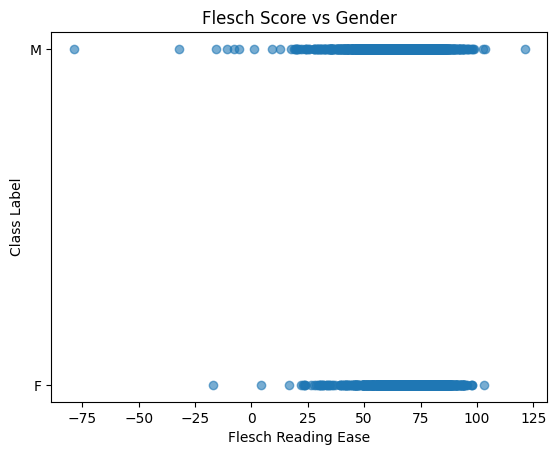

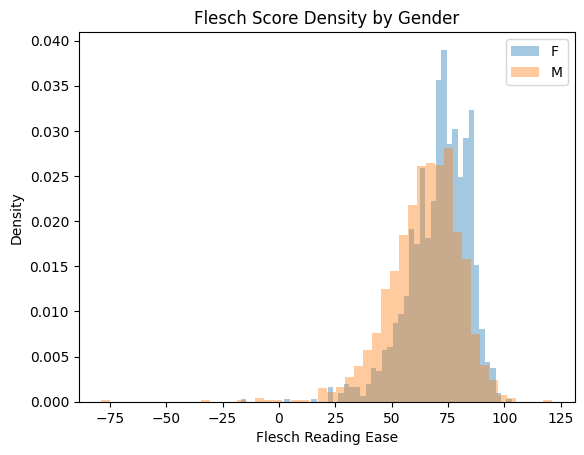


=== LogisticRegression ===
Accuracy: 61.46%
              precision    recall  f1-score   support

           F       0.60      0.60      0.60       310
           M       0.63      0.63      0.63       336

    accuracy                           0.61       646
   macro avg       0.61      0.61      0.61       646
weighted avg       0.61      0.61      0.61       646



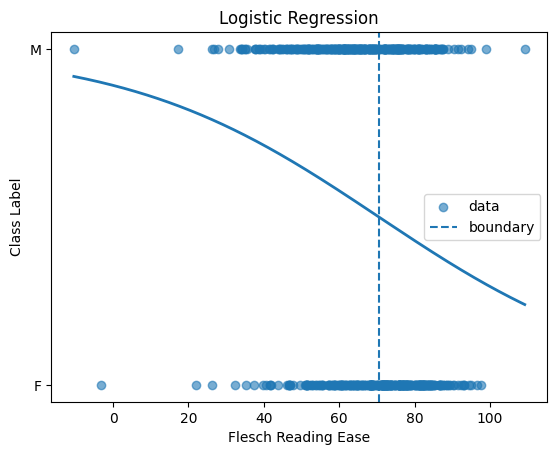


=== LinearSVC ===
Accuracy: 61.30%
              precision    recall  f1-score   support

           F       0.60      0.60      0.60       310
           M       0.63      0.63      0.63       336

    accuracy                           0.61       646
   macro avg       0.61      0.61      0.61       646
weighted avg       0.61      0.61      0.61       646



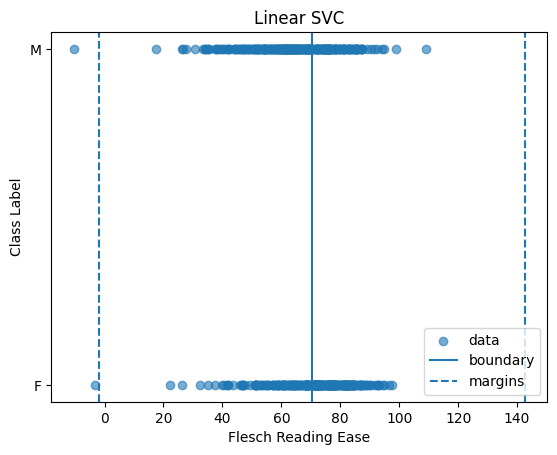


=== DecisionTree ===
Accuracy: 60.68%
              precision    recall  f1-score   support

           F       0.59      0.60      0.59       310
           M       0.62      0.61      0.62       336

    accuracy                           0.61       646
   macro avg       0.61      0.61      0.61       646
weighted avg       0.61      0.61      0.61       646



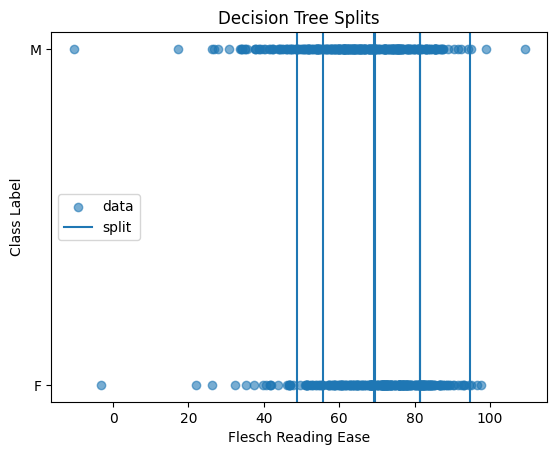


=== GaussianNB ===
Accuracy: 60.37%
              precision    recall  f1-score   support

           F       0.57      0.74      0.64       310
           M       0.67      0.48      0.56       336

    accuracy                           0.60       646
   macro avg       0.62      0.61      0.60       646
weighted avg       0.62      0.60      0.60       646



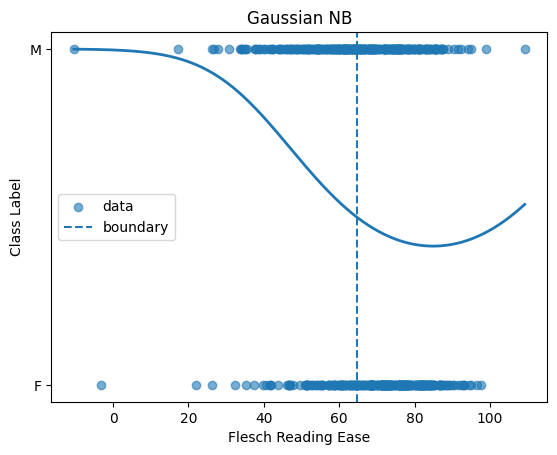

In [ ]:
class FleschScoreGenerator(BaseEstimator, TransformerMixin):
    """
    Computes the Flesch Reading Ease score for each blog post using textstat.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        scores = [textstat.flesch_reading_ease(text) for text in X]
        return np.array(scores).reshape(-1, 1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['gender'])
X = df['blog_text']

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scatter plot on the data
scores_train = FleschScoreGenerator().fit_transform(X_train).ravel()
plt.figure()
plt.scatter(scores_train, y_train, alpha=0.6)
plt.title('Flesch Score vs Gender')
plt.xlabel('Flesch Reading Ease')
plt.ylabel('Class Label')
plt.yticks([0, 1], le.classes_)
plt.show()

# Density histogram plot on the data
plt.figure()
for cls, label in enumerate(le.classes_):
    mask = (y_train == cls)
    plt.hist(scores_train[mask], bins=50, density=True, alpha=0.4, label=label)
plt.xlabel('Flesch Reading Ease')
plt.ylabel('Density')
plt.title('Flesch Score Density by Gender')
plt.legend()
plt.show()

scores_test = FleschScoreGenerator().transform(X_test).ravel()
xs = np.linspace(scores_test.min(), scores_test.max(), 500).reshape(-1, 1)

classifiers = {
    'LogisticRegression': LogisticRegression(),
    'LinearSVC':          LinearSVC(),
    'DecisionTree':       DecisionTreeClassifier(random_state=42, max_depth=3),
    'GaussianNB':         GaussianNB()
}

for name, clf in classifiers.items():
    pipeline = Pipeline([
        ('flesch', FleschScoreGenerator()),
        ('clf', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f'\n=== {name} ===')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    plt.figure()
    plt.scatter(scores_test, y_test, alpha=0.6, label='data')

    # Plot the decision boundaries for visualization
    if name == 'LogisticRegression':
        probs = pipeline.named_steps['clf'].predict_proba(xs)[:,1]
        plt.plot(xs.ravel(), probs, linewidth=2)
        w, b = pipeline.named_steps['clf'].coef_[0][0], pipeline.named_steps['clf'].intercept_[0]
        plt.axvline(-b/w, linestyle='--', label='boundary')
        plt.ylabel('Class Label')
        plt.title('Logistic Regression')

    elif name == 'LinearSVC':
        w, b = pipeline.named_steps['clf'].coef_[0][0], pipeline.named_steps['clf'].intercept_[0]
        th, m = -b/w, 1/abs(w)
        plt.axvline(th,        label='boundary')
        plt.axvline(th-m, linestyle='--', label='margins')
        plt.axvline(th+m, linestyle='--')
        plt.ylabel('Class Label')
        plt.title('Linear SVC')

    elif name == 'DecisionTree':
        splits = pipeline.named_steps['clf'].tree_.threshold[
            pipeline.named_steps['clf'].tree_.feature >= 0
        ]
        for i, s in enumerate(splits):
            plt.axvline(s, label='split' if i==0 else None)
        plt.ylabel('Class Label')
        plt.title('Decision Tree Splits')

    else:  # GaussianNB
        probs = pipeline.named_steps['clf'].predict_proba(xs)[:,1]
        plt.plot(xs.ravel(), probs, linewidth=2)
        ix = np.argmin(np.abs(probs - 0.5))
        plt.axvline(xs[ix], linestyle='--', label='boundary')
        plt.ylabel('Class Label')
        plt.title('Gaussian NB')

    plt.xlabel('Flesch Reading Ease')
    plt.yticks([0, 1], le.classes_)
    plt.legend()
    plt.show()


# Novel Approach 2 Sentiment Polarity Statistics

## Mean, Standard Deviation, Minimum, Maximum, Mean Absolute Difference,
## Flip Ratio, Positive Sentence Ratio, Negative Sentence Ratio, Neutral Sentence Ratio

In [ ]:
class SentimentFeaturesGenerator(BaseEstimator, TransformerMixin):
    """
    Computes 9 Sentiment polarity statistics for each blog post
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features_all = []
        for text in X:
            sentences = sent_tokenize(text)
            if len(sentences) == 0:
                features_all.append(np.zeros(9))
                continue

            # Compute polarity scores for each sentence using TextBlob
            polarity_scores = [TextBlob(sent).sentiment.polarity for sent in sentences]
            polarity_scores = np.array(polarity_scores)

            # Polarity statistics
            mean_sent = np.mean(polarity_scores) # 1. Mean
            std_sent = np.std(polarity_scores) # 2. Standard Deviation
            min_sent = np.min(polarity_scores) # 3. Minimum Score
            max_sent = np.max(polarity_scores) # 4. Maximum Score
            if len(polarity_scores) > 1: # 5. Mean Absolute difference
                avg_abs_diff = np.mean(np.abs(np.diff(polarity_scores)))
            else:
                avg_abs_diff = 0.0

            labels = []
            threshold = 0.05 # positive and negative sentence divison
            for score in polarity_scores:
                if score > threshold:
                    labels.append(1)  # positive
                elif score < -threshold:
                    labels.append(-1)  # negative
                else:
                    labels.append(0)  # neutral

            # 6. Flip ratio: proportion of sentences where polarity is different from previous sentence
            if len(labels) > 1:
                flip_count = sum(1 for i in range(1, len(labels)) if labels[i] != labels[i - 1])
                flip_ratio = flip_count / (len(labels) - 1)
            else:
                flip_ratio = 0.0

            total = len(polarity_scores)
            pos_count = sum(1 for s in polarity_scores if s > threshold)
            neg_count = sum(1 for s in polarity_scores if s < -threshold)
            neu_count = total - pos_count - neg_count
            pos_ratio = pos_count / total # 7. Positive sentence ratio
            neg_ratio = neg_count / total # 8. Negative sentence ratio
            neu_ratio = neu_count / total # 9. Neutral sentence ratio

            feat_vector = [
                mean_sent,
                std_sent,
                min_sent,
                max_sent,
                avg_abs_diff,
                flip_ratio,
                pos_ratio,
                neg_ratio,
                neu_ratio,
            ]
            features_all.append(feat_vector)
        return np.array(features_all)


X = df["blog_text"]
y = df["gender"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

classifiers = {
    "LinearSVC": LinearSVC(max_iter=10000),
    "NaiveBayes": MultinomialNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
}

all_features = FeatureUnion(
    [
        (
            "sentiment",
            Pipeline(
                [
                    ("sent_features", SentimentFeaturesGenerator()),
                    ("scaler", MinMaxScaler()),  # scaling the sentiment feature vector
                ]
            ),
        ),
        ("word_features", word_pipeline),
        ("word_class_features", word_class_pipeline),
        ("pos_ngram_features", pos_pipeline),
    ]
)

for clf_name, clf in classifiers.items():
    print("\n" + "=" * 40)
    print(f"Classifier: {clf_name}")

    if clf_name in ["DecisionTree", "RandomForest"]:
        pipeline = Pipeline([
            ('features', combined_features),
            ('to_dense', DenseGenerator()), # Sparst to Dense data conversion
            ('clf', clf)
        ])
    elif clf_name in ["NaiveBayes"]:
        pipeline = Pipeline([
            ('features', combined_features),
            ('to_dense', DenseGenerator()), # dense representation necessary for Min-Max Scaler
            ('scaler', MinMaxScaler()), # scaling to non negative range
            ('clf', clf)
        ])
    else:
        pipeline = Pipeline([
            ('features', combined_features),
            ('scaler', MaxAbsScaler()), # scaling a shorter range for efficiency
            ('clf', clf)
        ])

    pipeline.fit(X_train, y_train_enc)
    y_pred_enc = pipeline.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred_enc)
    print(f"Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))



Classifier: LinearSVC
Accuracy: 69.81%
Classification Report:
              precision    recall  f1-score   support

           F       0.67      0.72      0.69       310
           M       0.72      0.68      0.70       336

    accuracy                           0.70       646
   macro avg       0.70      0.70      0.70       646
weighted avg       0.70      0.70      0.70       646


Classifier: NaiveBayes
Accuracy: 66.87%
Classification Report:
              precision    recall  f1-score   support

           F       0.65      0.68      0.66       310
           M       0.69      0.65      0.67       336

    accuracy                           0.67       646
   macro avg       0.67      0.67      0.67       646
weighted avg       0.67      0.67      0.67       646


Classifier: DecisionTree
Accuracy: 56.50%
Classification Report:
              precision    recall  f1-score   support

           F       0.55      0.51      0.53       310
           M       0.58      0.62      0.60 

# Combined (Flesch Reading Ease Score + Sentiment Polarity Statistics)

In [ ]:
# Combined Flesch reading ease score and Sentiment Polarity statistics
combined_features = FeatureUnion([
    ('flesch_score', Pipeline([('flesch', FleschScoreGenerator())])),
    ('sentiment_features', Pipeline([('sentiment', SentimentFeaturesGenerator())])),
    ('word_features', word_pipeline),
    ('word_class_features', word_class_pipeline),
    ('pos_ngram_features', pos_pipeline)
])

X = df['blog_text']
y = df['gender']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

classifiers = {
    "LinearSVC": LinearSVC(),
    "NaiveBayes": MultinomialNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

for clf_name, clf in classifiers.items():
    print("\n" + "="*40)
    print(f"Classifier: {clf_name}")

    if clf_name in ["DecisionTree", "RandomForest"]:
        pipeline = Pipeline([
            ('features', combined_features),
            ('to_dense', DenseGenerator()), # Sparst to Dense data conversion
            ('clf', clf)
        ])
    elif clf_name in ["NaiveBayes"]:
        pipeline = Pipeline([
            ('features', combined_features),
            ('to_dense', DenseGenerator()), # dense representation necessary for Min-Max Scaler
            ('scaler', MinMaxScaler()), # scaling to non negative range
            ('clf', clf)
        ])
    else:
        pipeline = Pipeline([
            ('features', combined_features),
            ('scaler', MaxAbsScaler()), # scaling a shorter range for efficiency
            ('clf', clf)
        ])

    pipeline.fit(X_train, y_train_enc)
    y_pred_enc = pipeline.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred_enc)
    print(f"Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))



Classifier: LinearSVC
Accuracy: 70.59%
Classification Report:
              precision    recall  f1-score   support

           F       0.69      0.71      0.70       310
           M       0.72      0.70      0.71       336

    accuracy                           0.71       646
   macro avg       0.71      0.71      0.71       646
weighted avg       0.71      0.71      0.71       646


Classifier: NaiveBayes
Accuracy: 66.87%
Classification Report:
              precision    recall  f1-score   support

           F       0.65      0.68      0.66       310
           M       0.69      0.65      0.67       336

    accuracy                           0.67       646
   macro avg       0.67      0.67      0.67       646
weighted avg       0.67      0.67      0.67       646


Classifier: DecisionTree
Accuracy: 56.04%
Classification Report:
              precision    recall  f1-score   support

           F       0.54      0.59      0.56       310
           M       0.58      0.53      0.56 

## Cross Validation and Hyper Parameter Turning for Combined Features

In [ ]:
from sklearn.model_selection import GridSearchCV


# RandomForest hyperparameter tuning
rf_pipeline = Pipeline([
    ('features', combined_features),
    ('to_dense', DenseGenerator()),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'clf__n_estimators': [100, 300], # number of trees
    'clf__max_depth': [None, 10], # depth of the tree (No limit, 10 limit)
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3, # 3 fold Cross Validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train_enc)

print("RF best params:", rf_grid.best_params_)
print("RF CV accuracy: {:.2f}%".format(rf_grid.best_score_ * 100))
rf_best = rf_grid.best_estimator_
print("RF test accuracy: {:.2f}%".format(
    accuracy_score(y_test_enc, rf_best.predict(X_test)) * 100
))

# LinearSVC hyperparameter tuning
svc_pipeline = Pipeline([
    ('features', combined_features),
    ('scaler', MaxAbsScaler()),
    ('clf', LinearSVC(random_state=42, max_iter=10000))
])

svc_param_grid = {
    'clf__C': [0.1, 1, 10], # regularization
    'clf__tol': [1e-4, 1e-3], # tolerance
}

svc_grid = GridSearchCV(
    svc_pipeline,
    svc_param_grid,
    cv=3, # 3 fold Cross Validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
svc_grid.fit(X_train, y_train_enc)

print("\nSVC best params:", svc_grid.best_params_)
print("SVC CV accuracy: {:.2f}%".format(svc_grid.best_score_ * 100))
svc_best = svc_grid.best_estimator_
print("SVC test accuracy: {:.2f}%".format(
    accuracy_score(y_test_enc, svc_best.predict(X_test)) * 100
))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
RF best params: {'clf__max_depth': None, 'clf__n_estimators': 300}
RF CV accuracy: 65.55%
RF test accuracy: 67.34%
Fitting 3 folds for each of 6 candidates, totalling 18 fits

SVC best params: {'clf__C': 0.1, 'clf__tol': 0.0001}
SVC CV accuracy: 68.77%
SVC test accuracy: 70.43%


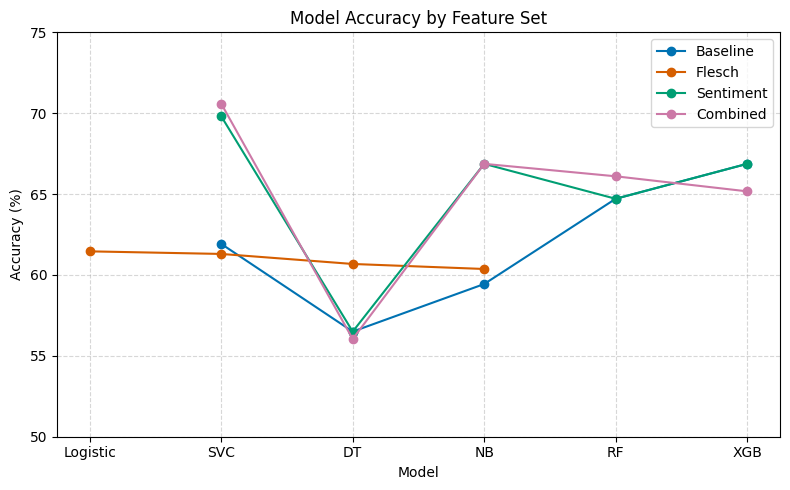

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the models and accuracy data
models = ['Logistic', 'SVC', 'DT', 'NB', 'RF', 'XGB']
data = {
    'Baseline':  [None, 61.92, 56.50, 59.44, 64.71, 66.87],
    'Flesch':    [61.46, 61.30, 60.68, 60.37, None, None],
    'Sentiment': [None, 69.81, 56.50, 66.87, 64.71, 66.87],
    'Combined':  [None, 70.59, 56.04, 66.87, 66.10, 65.17],
}

df = pd.DataFrame(data, index=models)

colors = {
    'Baseline': '#0072B2',
    'Flesch':   '#D55E00',
    'Sentiment':'#009E73',
    'Combined': '#CC79A7'
}

# Plot
plt.figure(figsize=(8, 5))
for feature_set in df.columns:
    plt.plot(
        df.index,
        df[feature_set],
        marker='o',
        label=feature_set,
        color=colors[feature_set]
    )

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Feature Set')
plt.legend()
plt.ylim(50, 75)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()